In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from util.utils import (get_paddle_ocr_model, run_ocr_model,
                        get_yolo_model, run_yolo_model,
                        remove_overlap,
                        get_caption_model, run_caption_model,
                        )

from PIL import Image
import numpy as np

/home/public/.miniconda3/envs/omni/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/home/public/.miniconda3/envs/omni/lib/python3.12/site-packages/paddle/utils/cpp_extension/extension_utils.py:711: UserWarning: No ccache found. Please be aware that recompiling all source files may be required. You can download and install ccache from: https://github.com/ccache/ccache/blob/master/doc/INSTALL.md
  warnings.warn(warning_message)


In [3]:
paddle_ocr_model = get_paddle_ocr_model()
yolo_model = get_yolo_model('./weights/icon_detect/model.pt')

caption_model = get_caption_model('./weights/icon_caption_florence')

Florence2LanguageForConditionalGeneration has generative capabilities, as `prepare_inputs_for_generation` is explicitly overwritten. However, it doesn't directly inherit from `GenerationMixin`. From 👉v4.50👈 onwards, `PreTrainedModel` will NOT inherit from `GenerationMixin`, and this model will lose the ability to call `generate` and other related functions.
  - If you're using `trust_remote_code=True`, you can get rid of this warning by loading the model with an auto class. See https://huggingface.co/docs/transformers/en/model_doc/auto#auto-classes
  - If you are the owner of the model architecture code, please modify your model class such that it inherits from `GenerationMixin` (after `PreTrainedModel`, otherwise you'll get an exception).
  - If you are not the owner of the model architecture class, please contact the model code owner to update it.


In [4]:
image_path = 'imgs/word.png'
image_pil = Image.open(image_path).convert('RGB')
image_arr = np.asarray(image_pil)

In [5]:
# run ocr
ocr_box_elems = run_ocr_model(paddle_ocr_model, image_arr, threshold=0.9)

print(len(ocr_box_elems))
print(ocr_box_elems[0])


45
BoxElement(type='text', bbox=array([        288,          12,         340,          26], dtype=float32), interactivity=False, content='Document 10.docx  General*  Last Modified: Just now ', source='box_ocr_content_ocr')


In [6]:
# run yolo
yolo_model_conf = dict(
    conf = 0.05, # yolo minimum confidence
    iou = 0.7, # yolo NMS iou threshold
    verbose = False
)
yolo_box_elems = run_yolo_model(yolo_model, image_pil, yolo_model_conf)

print(len(yolo_box_elems))
print(yolo_box_elems[0])

142
BoxElement(type='icon', bbox=array([     848.53,      88.313,      117.77,       66.12], dtype=float32), interactivity=True, content=None, source=None)


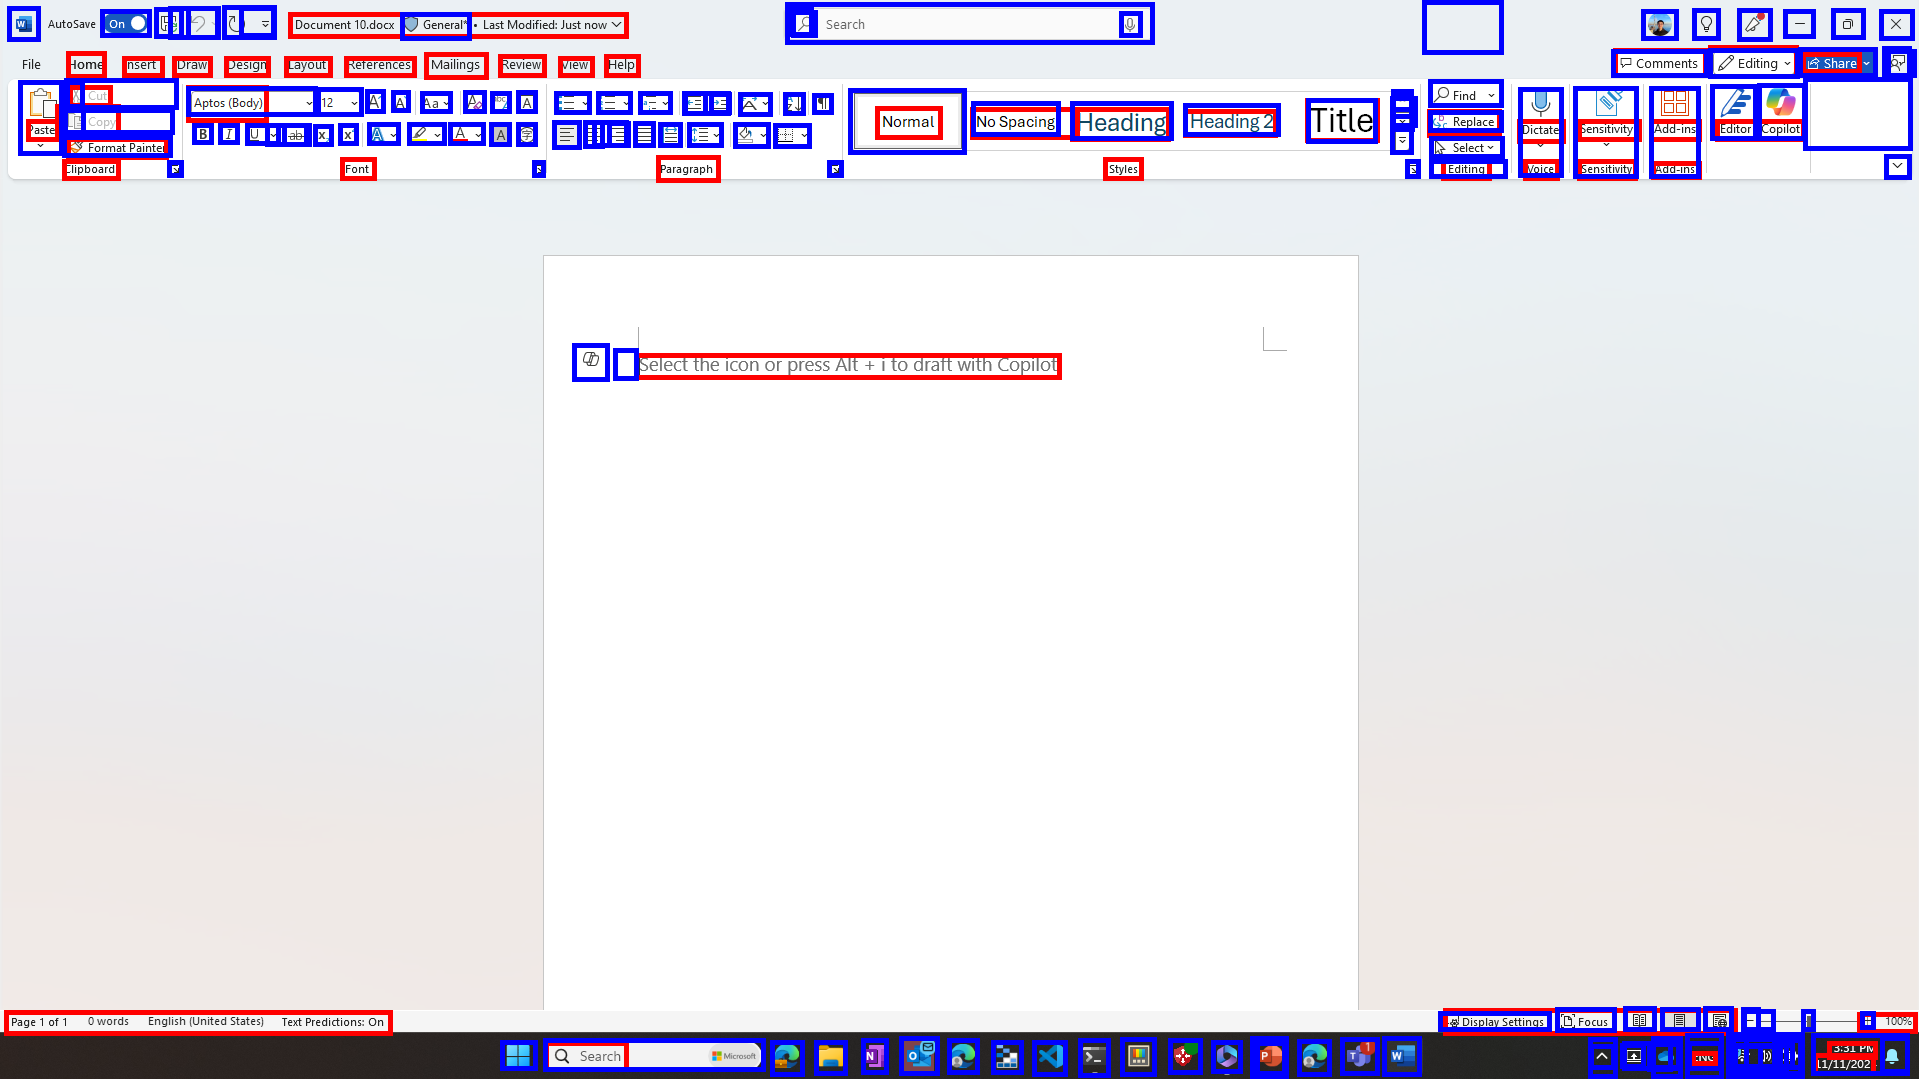

In [7]:
# check bboxes
from PIL import ImageDraw

bbox_vis = image_pil.copy()
draw = ImageDraw.ImageDraw(bbox_vis)

for box in ocr_box_elems:
    x, y, w, h = box.bbox
    draw.rectangle((x, y, x+w, y+h), outline='red', width=5)

for box in yolo_box_elems:
    x, y, w, h = box.bbox
    draw.rectangle((x, y, x+w, y+h), outline='blue', width=5)

display(bbox_vis)

In [8]:
# ocr로 찾은 박스와 yolo로 찾은 박스가 겹치는 경우를 처리해서 정리함
filtered_elems = remove_overlap(ocr_box_elems, yolo_box_elems)

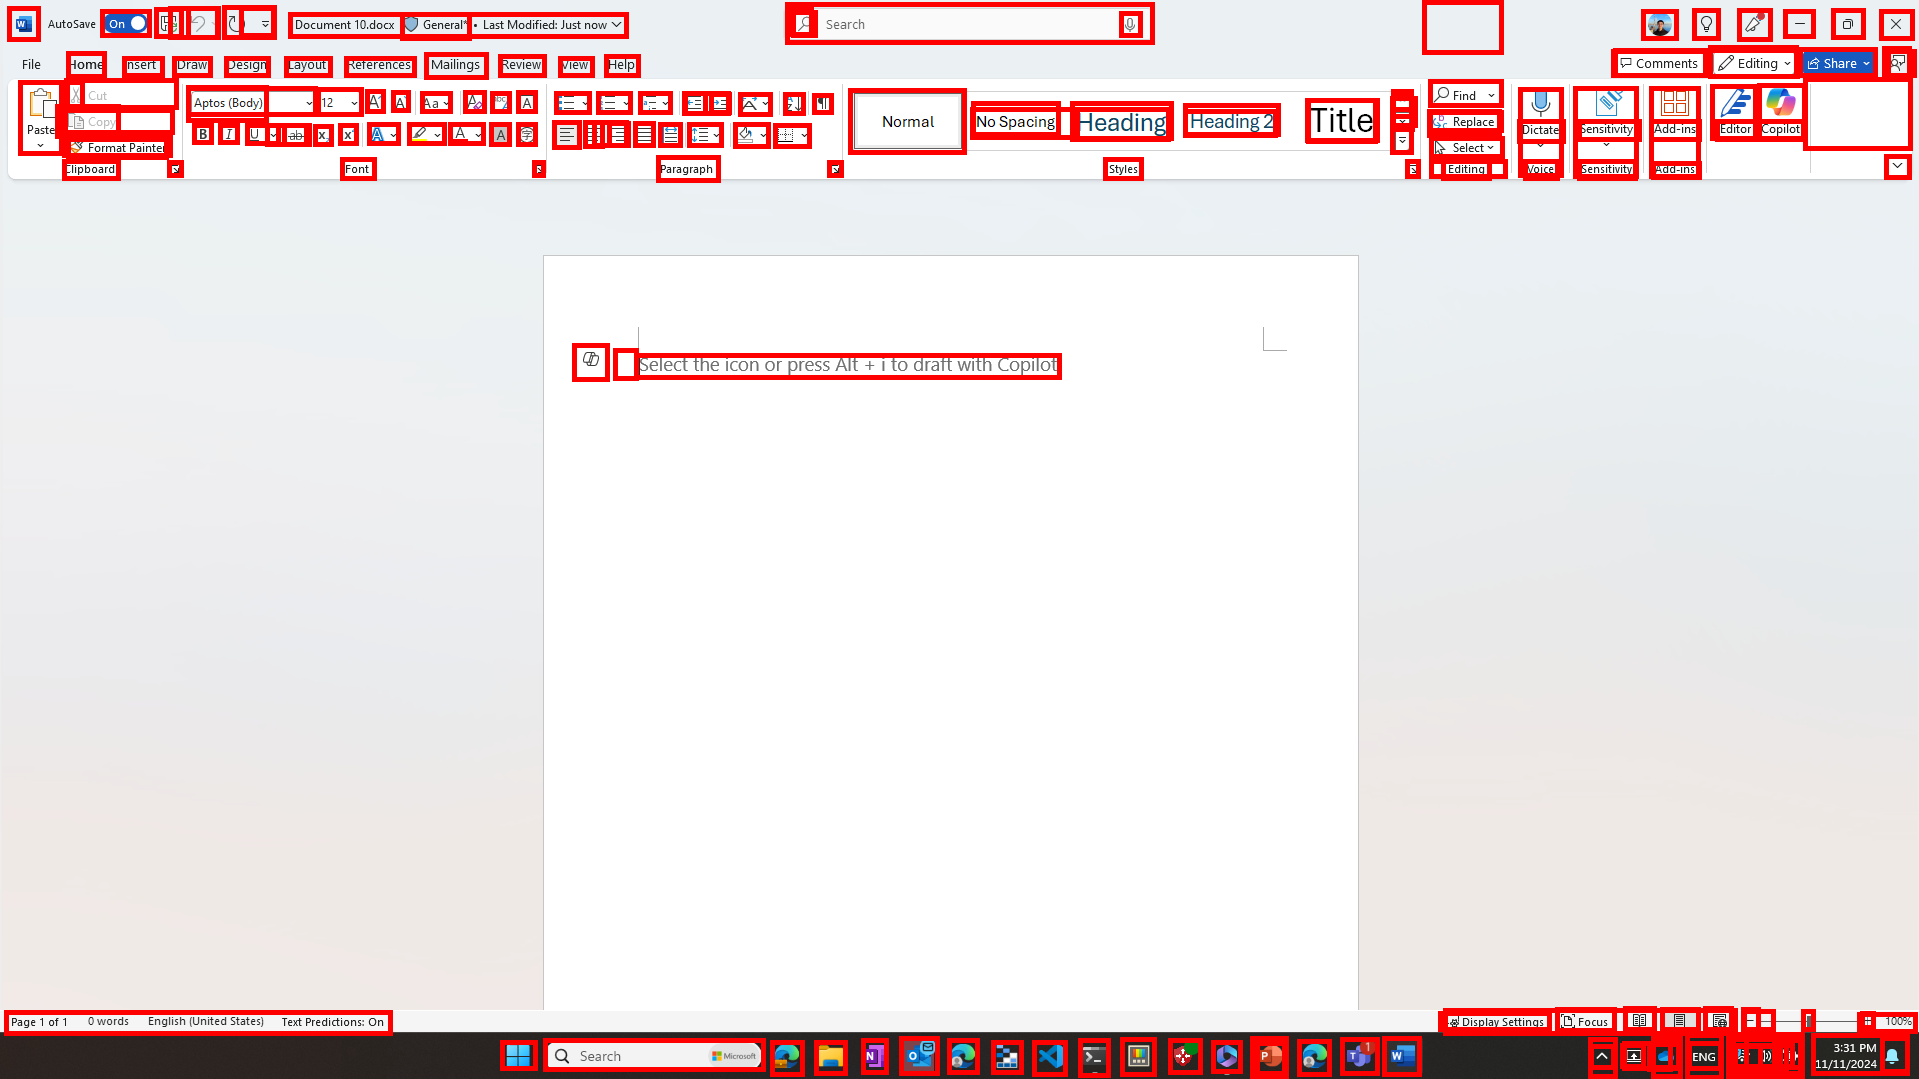

In [9]:
bbox_vis = image_pil.copy()
draw = ImageDraw.ImageDraw(bbox_vis)

for box in filtered_elems:
    x, y, w, h = box.bbox
    draw.rectangle((x, y, x+w, y+h), outline='red', width=5)

display(bbox_vis)

In [10]:
no_content_indices = [i for i in range(len(filtered_elems)) if filtered_elems[i].content is None]

bboxes_to_caption = np.array([filtered_elems[i].bbox for i in no_content_indices])
captions = run_caption_model(caption_model, image_arr, bboxes_to_caption)

for i, caption in zip(no_content_indices, captions):
    filtered_elems[i].content = caption

In [11]:
filtered_elems

[BoxElement(type='text', bbox=array([        288,          12,         340,          26], dtype=float32), interactivity=False, content='Document 10.docx  General*  Last Modified: Just now ', source='box_ocr_content_ocr'),
 BoxElement(type='text', bbox=array([         66,          51,          40,          27], dtype=float32), interactivity=False, content='Home', source='box_ocr_content_ocr'),
 BoxElement(type='text', bbox=array([        424,          52,          64,          27], dtype=float32), interactivity=False, content='Mailings', source='box_ocr_content_ocr'),
 BoxElement(type='text', bbox=array([        498,          54,          48,          23], dtype=float32), interactivity=False, content='Review', source='box_ocr_content_ocr'),
 BoxElement(type='text', bbox=array([        604,          54,          36,          23], dtype=float32), interactivity=False, content='Help', source='box_ocr_content_ocr'),
 BoxElement(type='text', bbox=array([       1613,          48,          94, 